In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

Implementing a **LSTM Neural Network** capable to predict the temperature "behavior" of a marine protected area with high coral coverage.   

## Ploting SST data (inputs)

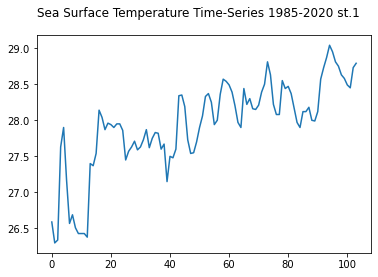

In [2]:
training_set = pd.read_csv('df1.csv')

training_set = training_set.iloc[:,1:2].values

plt.plot(training_set)
plt.suptitle('Sea Surface Temperature Time-Series 1985-2020 st.1')
plt.show()

In [3]:
training_set # temperatures

array([[26.59],
       [26.3 ],
       [26.34],
       [27.63],
       [27.9 ],
       [27.17],
       [26.57],
       [26.69],
       [26.51],
       [26.43],
       [26.43],
       [26.43],
       [26.38],
       [27.4 ],
       [27.37],
       [27.54],
       [28.14],
       [28.04],
       [27.87],
       [27.96],
       [27.94],
       [27.9 ],
       [27.95],
       [27.95],
       [27.86],
       [27.45],
       [27.57],
       [27.63],
       [27.71],
       [27.59],
       [27.63],
       [27.73],
       [27.87],
       [27.62],
       [27.75],
       [27.83],
       [27.82],
       [27.6 ],
       [27.67],
       [27.15],
       [27.5 ],
       [27.48],
       [27.6 ],
       [28.34],
       [28.35],
       [28.19],
       [27.73],
       [27.54],
       [27.55],
       [27.7 ],
       [27.9 ],
       [28.06],
       [28.33],
       [28.37],
       [28.25],
       [27.94],
       [28.  ],
       [28.36],
       [28.57],
       [28.54],
       [28.49],
       [28.39],
       [

## Training-Test Data/Tensors

In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

#transform time series to scale
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

#training and test data sizes
train_size = int(len(y) * 0.70)
test_size = len(y) - train_size

#Tensors
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## LSTM model

In [5]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out


## Training - Loss ==> model accuracy

In [6]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04322
Epoch: 100, loss: 0.01070
Epoch: 200, loss: 0.00888
Epoch: 300, loss: 0.00883
Epoch: 400, loss: 0.00877
Epoch: 500, loss: 0.00861
Epoch: 600, loss: 0.00825
Epoch: 700, loss: 0.00730
Epoch: 800, loss: 0.00686
Epoch: 900, loss: 0.00664
Epoch: 1000, loss: 0.00634
Epoch: 1100, loss: 0.00598
Epoch: 1200, loss: 0.00561
Epoch: 1300, loss: 0.00534
Epoch: 1400, loss: 0.00511
Epoch: 1500, loss: 0.00494
Epoch: 1600, loss: 0.00475
Epoch: 1700, loss: 0.00466
Epoch: 1800, loss: 0.00460
Epoch: 1900, loss: 0.00455


## Observed vs Predicted values

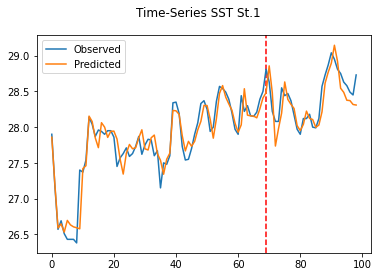

In [7]:
#Preparing validation(test) data for the prediction 
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

# transformation-normalization
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

# plot
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label = 'Observed')
plt.plot(data_predict, label = 'Predicted')
plt.suptitle('Time-Series SST St.1')
plt.legend()
plt.savefig('time-series-st1.png', dpi=100)
plt.show()